In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5, ), std = (0.5, ))])
trainset = torchvision.datasets.CIFAR10(root='D:/Downloads/DecisionTree_RandomForest', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=8, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='D:/Downloads/DecisionTree_RandomForest', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

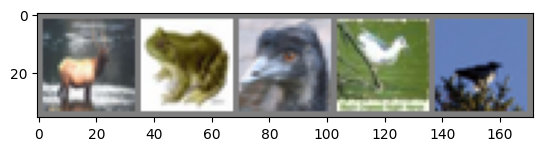

In [3]:
def imshow(img):
    img = img * 0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    imshow(torchvision.utils.make_grid(images[:5]))
    break

+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [4]:
def getModel(n_features):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_features, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    return model

+ Khởi tạo hàm loss function và phương thức optimizer

In [5]:
n_features = 32 * 32 * 3 
model = getModel(n_features)
lr = 0.01
optim = SGD(params = model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

+ Xây dựng hàm đánh giá model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Assuming 'model', 'trainloader', 'testloader', 'loss_fn', and 'device' are already defined

n_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce learning rate every 5 epochs

def evaluate(model, dataloader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_loss /= len(dataloader)
    return test_loss, accuracy

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    scheduler.step()  # Adjust the learning rate


Epoch [1/10], Loss: 1.7284, Accuracy: 39.11%, Test Loss: 1.5705, Test Accuracy: 45.66%
Epoch [2/10], Loss: 1.5093, Accuracy: 47.60%, Test Loss: 1.4928, Test Accuracy: 47.98%
Epoch [3/10], Loss: 1.4115, Accuracy: 51.18%, Test Loss: 1.4314, Test Accuracy: 49.65%
Epoch [4/10], Loss: 1.3451, Accuracy: 53.66%, Test Loss: 1.4034, Test Accuracy: 50.75%
Epoch [5/10], Loss: 1.2845, Accuracy: 55.72%, Test Loss: 1.3833, Test Accuracy: 51.56%
Epoch [6/10], Loss: 1.2018, Accuracy: 59.14%, Test Loss: 1.3525, Test Accuracy: 52.62%
Epoch [7/10], Loss: 1.1834, Accuracy: 60.07%, Test Loss: 1.3489, Test Accuracy: 52.78%
Epoch [8/10], Loss: 1.1741, Accuracy: 60.38%, Test Loss: 1.3469, Test Accuracy: 52.69%
Epoch [9/10], Loss: 1.1674, Accuracy: 60.79%, Test Loss: 1.3444, Test Accuracy: 52.68%
Epoch [10/10], Loss: 1.1605, Accuracy: 60.96%, Test Loss: 1.3442, Test Accuracy: 52.83%


+ Bắt đầu training và đánh giá model.

NameError: name 'train_losses' is not defined

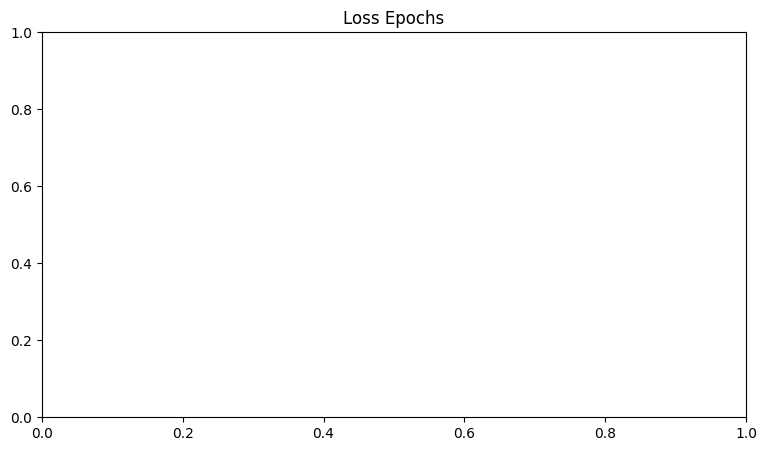

In [ ]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()

+ Dưới đây là bài tập về code from scratch

In [ ]:

def zScoreScaling(tensor):
    """
    Thực hiện chuẩn hóa dữ liệu theo phương pháp Z-score.

    Args:
        tensor: Tensor cần chuẩn hóa.

    Returns:
        Tensor đã được chuẩn hóa.
    """

    mean = torch.mean(tensor)
    std = torch.std(tensor)
    return (tensor - mean) / std

In [ ]:
def minMaxScaling(tensor):
    """
    Thực hiện chuẩn hóa dữ liệu theo phương pháp Min-Max.

    Args:
        tensor: Tensor cần chuẩn hóa.

    Returns:
        Tensor đã được chuẩn hóa.
    """

    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    return (tensor - min_val) / (max_val - min_val)

In [ ]:
class Linear:
 import torch

class Linear:
    def __init__(self, in_features, out_features):
        self.weight = torch.randn(out_features, in_features)
        self.bias = torch.randn(out_features)

    def forward(self, x):
        return torch.matmul(x, self.weight.T) + self.bias

# Tạo một đối tượng của lớp Linear
linear = Linear(3, 2)  # 3 đặc trưng đầu vào, 2 đặc trưng đầu ra

# Tạo tensor đầu vào
tensor = torch.tensor([1.0, 2.0, 3.0])

# Thực hiện phép biến đổi tuyến tính
output = linear.forward(tensor)

# In kết quả
print(output)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")
    

tensor([-1.7054,  6.1657])
Weight = tensor([[-1.5233,  0.9854, -0.6535],
        [ 1.1774,  1.1945,  0.7815]])
Bias = tensor([-0.1923,  0.2549])


In [ ]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


tensor([[-1.4606, -1.0954, -0.7303],
        [-0.3651,  0.0000,  0.3651],
        [ 0.7303,  1.0954,  1.4606]])
tensor([[0.0000, 0.1250, 0.2500],
        [0.3750, 0.5000, 0.6250],
        [0.7500, 0.8750, 1.0000]])


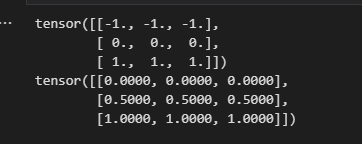

In [ ]:
tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")

tensor([-2.4673,  7.6823])
Weight = tensor([[ 0.2811,  0.7611, -1.4366],
        [ 0.7849,  0.1620,  1.8561]])
Bias = tensor([0.0393, 1.0052])
